# Interactive Example

## 1. Run GaMMA in terminal or use QuakeFlow API

Note: Please only use the QuakeFlow API for debugging and testing on small datasets. Do not run large jobs using the QuakeFlow API. The computational cost can be high for us.

```bash
uvicorn --app-dir=gamma app:app --reload --port 8002
```

In [37]:
import requests
import json
import pandas as pd
import os

In [38]:
# GAMMA_API_URL = "http://127.0.0.1:8002"
GAMMA_API_URL = "http://test.quakeflow.com:8002"

## 2. Prepare test data

- Download test data: PhaseNet picks of the 2019 Ridgecrest earthquake sequence
1. picks file: picks.json
2. station information: stations.csv
3. events in SCSN catalog: events.csv
4. config file: config.pkl

```bash
wget https://github.com/wayneweiqiang/GMMA/releases/download/test_data/test_data.zip
unzip test_data.zip
```

In [39]:
!wget https://github.com/wayneweiqiang/GMMA/releases/download/test_data/test_data.zip
!unzip test_data.zip

In [40]:
data_dir = lambda x: os.path.join("test_data", x)
station_csv = data_dir("stations.csv")
pick_json = data_dir("picks.json")
catalog_csv = data_dir("catalog_gamma.csv")
picks_csv = data_dir("picks_gamma.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

## set config
config = {'xlim_degree': [-118.004, -117.004], 
          'ylim_degree': [35.205, 36.205],
          'z(km)': [0, 41]}

## read stations
stations = pd.read_csv(station_csv, delimiter="\t")
stations = stations.rename(columns={"station":"id"})
stations_json = json.loads(stations.to_json(orient="records"))

## read picks
picks = pd.read_json(pick_json).sort_values("timestamp").iloc[:500]
picks["timestamp"] = picks["timestamp"].apply(lambda x: x.isoformat(timespec='milliseconds'))
picks_json = json.loads(picks.to_json(orient="records"))

## run association
result = requests.post(f"{GAMMA_API_URL}/predict", json= {
                                    "picks":picks_json, 
                                    "stations":stations_json,
                                    "config": config
                                    })

result = result.json()
# catalog_gamma = json.loads(result["catalog"])
# picks_gamma = json.loads(result["picks"])
catalog_gamma = result["catalog"]
picks_gamma = result["picks"]

## show result
print("GaMMA catalog:")
display(pd.DataFrame(catalog_gamma))
# print("GaMMA association:")
# display(pd.DataFrame(picks_gamma))

GaMMA catalog:


,time,x(km),y(km),z(km),magnitude,sigma_time,sigma_amp,cov_time_amp,event_index,gamma_score,longitude,latitude,depth(m)
0,2019-07-04T17:02:54.965,0.927555,0.537344,17.021468,4.350374,0.316631,0.328227,0.048226,0,98.000000,-117.493750,35.709843,17021.468316
1,2019-07-04T17:04:02.621,-0.744277,-0.045924,13.792492,2.049378,0.276628,0.453056,0.091567,1,33.000000,-117.512224,35.704586,13792.492349
2,2019-07-04T17:05:01.730,-1.148261,-1.711104,14.179332,1.102175,0.512811,0.452310,0.154577,2,12.999681,-117.516686,35.689578,14179.332013
3,2019-07-04T17:05:05.414,0.215675,0.287395,13.076593,1.334058,0.396388,0.328085,0.063611,3,49.974487,-117.501617,35.707590,13076.592693
4,2019-07-04T17:05:47.941,-1.206848,0.503239,14.708493,0.602850,0.345557,0.457805,0.122758,4,17.000000,-117.517336,35.709535,14708.493265
5,2019-07-04T17:06:23.953,0.757559,0.484171,12.128244,0.754060,0.468769,0.445306,0.135873,5,43.975448,-117.495629,35.709363,12128.243903
6,2019-07-04T17:07:54.676,-5.384101,-2.097088,14.983540,-0.105193,0.261254,0.390208,0.076532,6,10.969988,-117.563480,35.686085,14983.539676
7,2019-07-04T17:08:26.461,1.040260,2.096684,10.475130,0.519692,0.757694,0.322940,0.101371,7,47.024470,-117.492502,35.723896,10475.130398
8,2019-07-04T17:08:52.132,3.346468,0.914026,9.466015,0.249863,0.114455,0.381004,0.005393,8,10.000000,-117.467018,35.713232,9466.015214
9,2019-07-04T17:09:19.720,1.100291,0.445405,16.689147,2.420884,0.305906,0.312776,0.027236,9,98.000000,-117.491841,35.709014,16689.146500


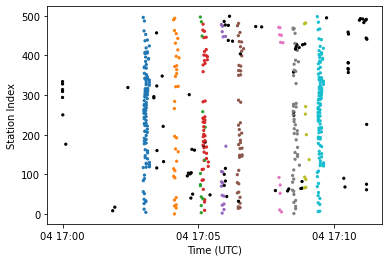

In [42]:
from datetime import datetime
import matplotlib.pyplot as plt
picks_gamma = pd.DataFrame(picks_gamma)
picks_gamma = picks_gamma.sort_values("id").reset_index(drop=True)
plt.figure()
plt.scatter(picks_gamma["timestamp"].apply(lambda x: datetime.fromisoformat(x)), picks_gamma.index, s=5, c=picks_gamma["event_index"].apply(lambda x: "k" if x==-1 else f"C{x}"))
plt.xlabel("Time (UTC)")
plt.ylabel("Station Index")
plt.show()